In [1]:
#import necessary processes for the procedures
import csv
import matplotlib.pyplot as plt
import datetime
from datetime import datetime as dt
import numpy

In [3]:
#Function: Read in a file based on a date (later will change to variable, loop through)
def readFile (filename, folder):   
    x = list(csv.reader(open(folder+'/'+filename)))   #read in the csv file
    return x

In [4]:
#Function: remove the header row if it exists and clean it from the import
def setheader(x):
    x_head = x[0]
    return x_head

def cleantop (x,zz):
    if(x[0][0] == zz):
        del x[0]
    return x

In [5]:
#Read in a dataset to 'ds' variable, save headers for reference to 'ds_headers'
ds = readFile ('ethiopia.csv','gfi-usb')
ds_headers = setheader(ds)
ds = cleantop(ds,'id')

In [6]:
#Check the data
print(len(ds))
print(ds_headers)

68684
['id', 'commodity_id', 'src_country_id', 'country_id', 'month', 'quantity_1', 'quantity_2', 'value', 'is_import', 'currency', 'unit_1_id', 'unit_2_id', 'vessel_value', 'vessel_weight', 'containerized_vessel_value', 'containerized_vessel_weight', 'ts']


In [7]:
#Function: Confirm that a value can be cast to a float
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [8]:
#Function: get the average value for the data points in a given month for the dataset. 
#Called in the main 'plot_commodity' procedure
#Requires:
#   a table of distinct dates that appear
#   a list of the date points
#   a list of the price points
def get_monthly_baseline(dist_dates, date_points, price_points):
    amt = [0] * len(dist_dates)
    cnt = [0] * len(dist_dates)
    ap = [0] * len(dist_dates)
    for i in range (0,len(date_points)):
        uv = dist_dates.index(date_points[i])
        cnt[uv] += 1
        amt[uv] += price_points[i]
    for j in range(0,len(dist_dates)):
        ap[j] = amt[j]/cnt[j]
    return ap

In [9]:
#Function: a function that returns and prints all data points that fall outside of the t_stat threshold (e.g. 1.96 for 95% CI)
#Called in the main 'plot_commodity' procedure
#Requires:
#   a list of the date points
#   a list of the price points
#   a table of distinct dates that appear
#   a table of the monthly averages, generated in the 'get_monthly_baseline' function

def normalize_and_id(dates, prices, dist_dates, month_base, t_thresh):
    #Create the normalized price dataset
    norm_price =[]
    for i in range(0,len(prices)):
        price = prices[i]
        base = month_base[dist_dates.index(dates[i])]
        norm_price.append(price-base)
    #Calculate standard deviation
    sv = numpy.std(norm_price, axis=0)
    #Flag all points outside of 1.96 sds as anomalous orders
    anom_orders = []
    for j in range(0,len(norm_price)):
        if norm_price[j]/sv > t_thresh:
            anom_orders.append(['Date: '+str(dates[j])+' order price: '+str(prices[j])+' T-stat: '+str(norm_price[j]/sv)])
            
    print(anom_orders)

In [10]:
# Main Function that takes in a commodity ID, a data set (ds), and a currency and units to filter on
# This procedure: 1) plots the relevant data, 2) creates a monthly baseline, and 3) calculates normalized values and prints out
# any rows outside the threshold (defaulted to 1.96 to represent a 95% CI).
def plot_commodity (cid, data, currency, units, t_thresh):
    commodity_id = cid
    dataset = data
    ids = []
    for i in range(0,len(dataset)):
        if int(dataset[i][1]) == commodity_id and is_number(dataset[i][7]) and is_number(dataset[i][5]):
            if int(dataset[i][5]) > 0 and dataset[i][9] == currency and dataset[i][10] == units:
                ids.append(i)
    #print(ids)
    x_out = []
    y_out = []
    x_in = []
    y_in = []
    for id in ids:
        if dataset[id][8] == 't':
            x_out.append(dt.strptime(dataset[id][4], '%Y-%m-%d').date())
            y_out.append(float(dataset[id][7])/float(dataset[id][5]))
        else:
            x_in.append(dt.strptime(dataset[id][4], '%Y-%m-%d').date())
            y_in.append(float(dataset[id][7])/float(dataset[id][5]))
        dist_dates = []
    for i in x_out:
        if i not in dist_dates:
            dist_dates.append(i)
        else:
            pass
    export_val, = plt.plot(x_out,y_out,'ro',label='exports')
    import_val, = plt.plot(x_in,y_in,'bo',label='imports')
    plt.ylabel('price per unit')
    plt.xlabel('month')
    plt.legend()
    plt.show()
    month_base = get_monthly_baseline(dist_dates, x_out,y_out)
    #for i in range(0,len(dist_dates)):
    #    print (str(dist_dates[i])+' - '+str(month_base[i]))
    print('### Printing all points that fall outside of normalized threshold ###')
    normalize_and_id(x_out, y_out, dist_dates, month_base, t_thresh)

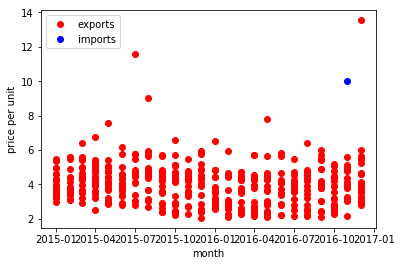

### Printing all points that fall outside of normalized threshold ###
[['Date: 2015-05-01 order price: 7.55 T-stat: 2.68383682845'], ['Date: 2015-07-01 order price: 11.6 T-stat: 5.73899557446'], ['Date: 2015-08-01 order price: 9.047619047619047 T-stat: 3.63574527744'], ['Date: 2015-10-01 order price: 6.580669144981413 T-stat: 2.26077968795'], ['Date: 2016-01-01 order price: 6.5240248226950355 T-stat: 2.37861034538'], ['Date: 2016-02-01 order price: 5.924594594594595 T-stat: 2.07321264893'], ['Date: 2016-05-01 order price: 7.79 T-stat: 3.49741277286'], ['Date: 2016-08-01 order price: 6.384136967155835 T-stat: 2.28313500144'], ['Date: 2016-12-01 order price: 13.544444444444444 T-stat: 7.65627400857']]


In [11]:
#Here's a trial run - in this case:
# Plotting coffee exports (and one import) for Ethiopia
# Filtering to only entrees in Euros and measured in kilos (all entries)
# Printing any points that fall outside a 95% confidence interval
plot_commodity(28671,ds,'EUR','24', 1.96)